## Classifying streetsign images
Using convolutional neural nets in Keras

In [9]:
import os
import skimage.io
from skimage import transform
from skimage.color import rgb2gray
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.utils import to_categorical

Load the data

In [3]:
def load_data(data_directory):
    directories = [d for d in os.listdir(data_directory) 
                   if os.path.isdir(os.path.join(data_directory, d))]
    labels = []
    images = []
    for d in directories:
        label_directory = os.path.join(data_directory, d)
        file_names = [os.path.join(label_directory, f) 
                      for f in os.listdir(label_directory) 
                      if f.endswith(".ppm")]
        for f in file_names:
            images.append(skimage.io.imread(f))
            labels.append(int(d))
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

In [4]:
images, labels = load_data("Training")

Resize the images to 28x28 pixels  
Convert the images to grayscale  
Reshape to 28x28x1 (instead of 28x28)

In [5]:
print(images.size)
print(len(labels))
print(len(set(labels)))

4575
4575
62


Looks like there are 62 distinct labels. And the number of images matches the number of labels - always good to check!

The distribution of label classes:

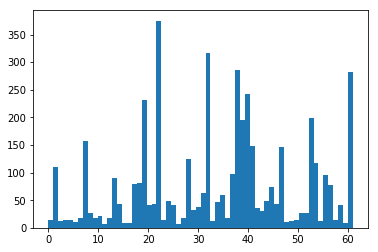

In [10]:
plt.hist(labels, 62)
plt.show()

What do the various sign types look like?

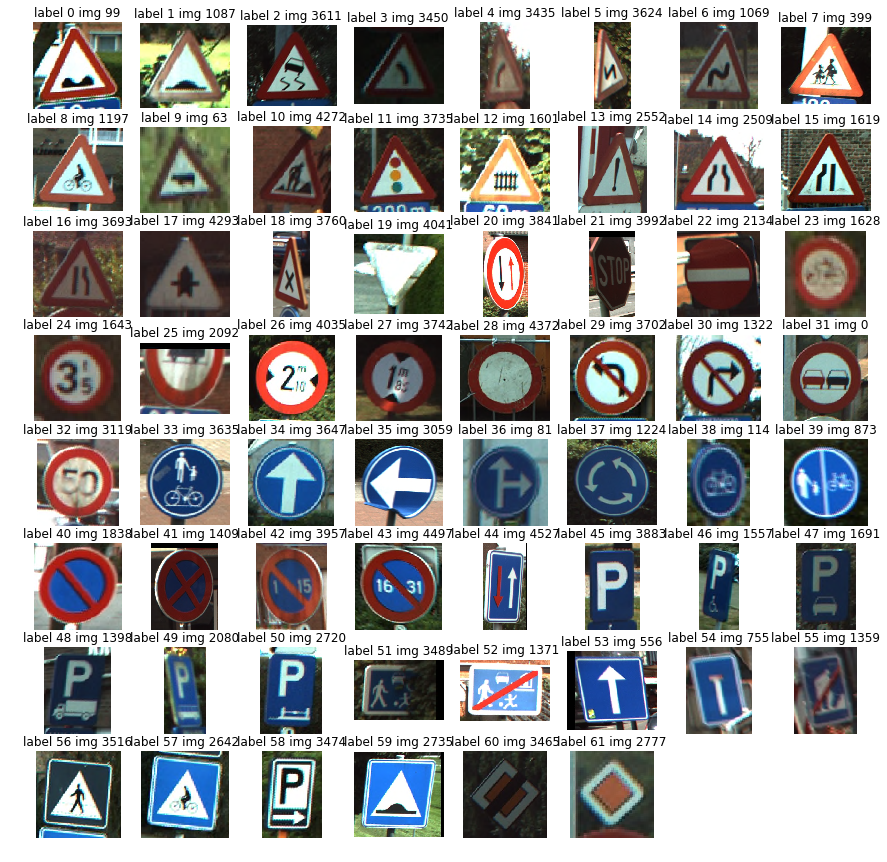

In [11]:
unique_labels = set(labels)
plt.figure(figsize=(15,15))

i=1
for label in unique_labels:
    indx = np.where(labels==label)[0][0]
    image = images[indx]
    plt.subplot(8, 8, i)
    plt.imshow(image)
    plt.axis('off')
    plt.title("label {} img {}".format(label, indx))
    i=i+1
plt.show()

Some of the sign images have different dimensions than others. The function below scales the images so they're all the same dimensions. It also converts them to grayscale. For classification, like I'm doing here, grayscale is supposed to work better. For detection, color is generally better.

In [13]:
def transform_images(images):
    images28 = [transform.resize(image, (28,28)) for image in images]
    images28 = np.array(images28)
    images28 = rgb2gray(images28)
    images28 = images28.reshape(-1, 28, 28, 1)
    return images28

In [14]:
images28 = transform_images(images)

/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Train-validation set split. The test data is provided in a separate folder.

In [15]:
X_train, X_val, y_train, y_val = train_test_split(images28, labels, test_size=0.20, random_state=42)

One-hot the labels (make into a 2D array of 0's and 1's, rather than a 1D array of categories)

In [16]:
y_train_one_hot = to_categorical(y_train)
y_val_one_hot = to_categorical(y_val)

In [17]:
X_train.shape,X_val.shape,y_train_one_hot.shape,y_val_one_hot.shape

((3660, 28, 28, 1), (915, 28, 28, 1), (3660, 62), (915, 62))

Load in the test data and transform it to match the training set.

In [18]:
test_images, test_labels = load_data('Testing')
X_test = transform_images(test_images)
y_test_one_hot = to_categorical(test_labels)

To start with, I'm building a single convolutional layer (3x3 filter) followed by a max-pooling layer (2x2). Then you always need to flatten that result and put it into a fully connected (Dense) layer with a softmax activation function to determine if each node is on or off (the image belongs to or does not belong to that class). The number of nodes in the final Dense layer is the number of unique street signs we have - 62.

This first model will use old-fashioned stochastic gradient descent as the optimizer.

In [19]:
num_classes = 62

In [20]:
cnn_model = Sequential()
cnn_model.add(Conv2D(32, kernel_size=(3,3), activation='linear', input_shape=(28,28,1), padding='same'))
cnn_model.add(LeakyReLU(alpha=0.1))
cnn_model.add(MaxPooling2D((2,2), padding='same'))
cnn_model.add(Flatten())
cnn_model.add(Dense(num_classes, activation='softmax'))

cnn_model.compile(loss=keras.losses.categorical_crossentropy, optimizer='sgd', metrics=['accuracy'])

In [21]:
cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 62)                388926    
Total params: 389,246
Trainable params: 389,246
Non-trainable params: 0
_________________________________________________________________


The above built the architecture of the neural net, now I need to fit it to the data.

I'm going to start out using a batch size of 64 and 20 epochs. A higher batch size of 128 or 256 can speed up the learning rate/model convergence, but is more memory intensive. A batch size which is too high can also decrease test set accuracy, as 

In [22]:
batch_size = 64
epochs = 20

In [23]:
trained = cnn_model.fit(X_train, y_train_one_hot, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(X_val, y_val_one_hot))

Train on 3660 samples, validate on 915 samples
Epoch 1/20
3660/3660 [==============================] - 3s 809us/step - loss: 3.8285 - acc: 0.0932 - val_loss: 3.5938 - val_acc: 0.1366
Epoch 2/20
3660/3660 [==============================] - 3s 810us/step - loss: 3.4662 - acc: 0.1708 - val_loss: 3.3982 - val_acc: 0.2131
Epoch 3/20
3660/3660 [==============================] - 3s 695us/step - loss: 3.2543 - acc: 0.2552 - val_loss: 3.1835 - val_acc: 0.2765
Epoch 4/20
3660/3660 [==============================] - 3s 778us/step - loss: 3.0242 - acc: 0.3363 - val_loss: 2.9721 - val_acc: 0.3071
Epoch 5/20
3660/3660 [==============================] - 3s 851us/step - loss: 2.7837 - acc: 0.3945 - val_loss: 2.7022 - val_acc: 0.3978
Epoch 6/20
3660/3660 [==============================] - 3s 736us/step - loss: 2.5412 - acc: 0.4467 - val_loss: 2.5475 - val_acc: 0.4437
Epoch 7/20
3660/3660 [==============================] - 3s 826us/step - loss: 2.3242 - acc: 0.5049 - val_loss: 2.3270 - val_acc: 0.4776
E

In [24]:
cnn_model.evaluate(X_test, y_test_one_hot)

2520/2520 [==============================] - 1s 226us/step


[1.3977842254298074, 0.6484126984126984]

Okay, so it looks like the accuracy is okay but not amazing, but the model is overfit (loss increases and accuracy decreases in both the validation and testing sets). This means the network is "memorizing" the training data, and therefore doesn't generalize well to the validation or testing data.

Before addressing the overfitting, let's just compare the Adam optimizer to SGD.

In [25]:
cnn_model = Sequential()
cnn_model.add(Conv2D(32, kernel_size=(3,3), activation='linear', input_shape=(28,28,1), padding='same'))
cnn_model.add(LeakyReLU(alpha=0.1))
cnn_model.add(MaxPooling2D((2,2), padding='same'))
cnn_model.add(Flatten())
cnn_model.add(Dense(num_classes, activation='softmax'))

cnn_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

trained = cnn_model.fit(X_train, y_train_one_hot, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(X_val, y_val_one_hot))

cnn_model.evaluate(X_test, y_test_one_hot)

Train on 3660 samples, validate on 915 samples
Epoch 1/20
3660/3660 [==============================] - 3s 801us/step - loss: 2.9006 - acc: 0.3847 - val_loss: 2.0225 - val_acc: 0.5650
Epoch 2/20
3660/3660 [==============================] - 3s 720us/step - loss: 1.3766 - acc: 0.7098 - val_loss: 1.1152 - val_acc: 0.7770
Epoch 3/20
3660/3660 [==============================] - 3s 724us/step - loss: 0.7623 - acc: 0.8426 - val_loss: 0.7646 - val_acc: 0.8284
Epoch 4/20
3660/3660 [==============================] - 3s 722us/step - loss: 0.4911 - acc: 0.8959 - val_loss: 0.5806 - val_acc: 0.8721
Epoch 5/20
3660/3660 [==============================] - 3s 735us/step - loss: 0.3519 - acc: 0.9284 - val_loss: 0.5195 - val_acc: 0.8732
Epoch 6/20
3660/3660 [==============================] - 3s 743us/step - loss: 0.2623 - acc: 0.9475 - val_loss: 0.4289 - val_acc: 0.8929
Epoch 7/20
3660/3660 [==============================] - 3s 740us/step - loss: 0.2038 - acc: 0.9587 - val_loss: 0.4224 - val_acc: 0.8842
E

[0.4726845214734711, 0.8853174601282392]

This optimizer definitely works a lot faster - exceeding the final SGD accuracy by the third epoch. Still looks like things are overfit though. A dropout layer is a good way to address overfitting by randomly "shutting off" some of the nodes during each epoch, making the model find new connections around them. This helps prevent the model from memorizing paths that only work for the training set.

In [26]:
cnn_model = Sequential()
cnn_model.add(Conv2D(32, kernel_size=(3,3), activation='linear', input_shape=(28,28,1), padding='same'))
cnn_model.add(LeakyReLU(alpha=0.1))
cnn_model.add(MaxPooling2D((2,2), padding='same'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Flatten())
cnn_model.add(Dense(num_classes, activation='softmax'))

cnn_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

trained = cnn_model.fit(X_train, y_train_one_hot, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(X_val, y_val_one_hot))

cnn_model.evaluate(X_test, y_test_one_hot)

Train on 3660 samples, validate on 915 samples
Epoch 1/20
3660/3660 [==============================] - 3s 917us/step - loss: 3.1318 - acc: 0.3109 - val_loss: 2.3503 - val_acc: 0.5344
Epoch 2/20
3660/3660 [==============================] - 3s 831us/step - loss: 1.7228 - acc: 0.6399 - val_loss: 1.3760 - val_acc: 0.7005
Epoch 3/20
3660/3660 [==============================] - 3s 800us/step - loss: 1.0063 - acc: 0.7730 - val_loss: 0.9390 - val_acc: 0.7902
Epoch 4/20
3660/3660 [==============================] - 3s 814us/step - loss: 0.6604 - acc: 0.8475 - val_loss: 0.7176 - val_acc: 0.8295
Epoch 5/20
3660/3660 [==============================] - 3s 828us/step - loss: 0.4933 - acc: 0.8847 - val_loss: 0.5874 - val_acc: 0.8557
Epoch 6/20
3660/3660 [==============================] - 3s 876us/step - loss: 0.3670 - acc: 0.9216 - val_loss: 0.5113 - val_acc: 0.8798
Epoch 7/20
3660/3660 [==============================] - 3s 849us/step - loss: 0.3066 - acc: 0.9295 - val_loss: 0.4367 - val_acc: 0.8885
E

[0.39946090312940735, 0.9007936506044297]

Still looks overfit. How about adding another fully connected layer with another dropout?

In [27]:
cnn_model = Sequential()
cnn_model.add(Conv2D(32, kernel_size=(3,3), activation='linear', input_shape=(28,28,1), padding='same'))
cnn_model.add(LeakyReLU(alpha=0.1))
cnn_model.add(MaxPooling2D((2,2), padding='same'))
cnn_model.add(Dropout(0.3))
cnn_model.add(Flatten())
cnn_model.add(Dense(64, activation='linear'))
cnn_model.add(LeakyReLU(alpha=0.1))
cnn_model.add(Dropout(0.4))
cnn_model.add(Dense(num_classes, activation='softmax'))

cnn_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

trained = cnn_model.fit(X_train, y_train_one_hot, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(X_val, y_val_one_hot))

cnn_model.evaluate(X_test, y_test_one_hot)

Train on 3660 samples, validate on 915 samples
Epoch 1/20
3660/3660 [==============================] - 3s 945us/step - loss: 3.4352 - acc: 0.2134 - val_loss: 2.7633 - val_acc: 0.4197
Epoch 2/20
3660/3660 [==============================] - 3s 809us/step - loss: 2.3977 - acc: 0.4699 - val_loss: 1.7946 - val_acc: 0.6197
Epoch 3/20
3660/3660 [==============================] - 3s 799us/step - loss: 1.6947 - acc: 0.6022 - val_loss: 1.2563 - val_acc: 0.6896
Epoch 4/20
3660/3660 [==============================] - 3s 845us/step - loss: 1.2570 - acc: 0.6874 - val_loss: 0.9491 - val_acc: 0.7749
Epoch 5/20
3660/3660 [==============================] - 3s 811us/step - loss: 0.9933 - acc: 0.7462 - val_loss: 0.7390 - val_acc: 0.8098
Epoch 6/20
3660/3660 [==============================] - 3s 851us/step - loss: 0.7688 - acc: 0.7975 - val_loss: 0.6027 - val_acc: 0.8415
Epoch 7/20
3660/3660 [==============================] - 3s 826us/step - loss: 0.6619 - acc: 0.8205 - val_loss: 0.5433 - val_acc: 0.8579
E

[0.3457938026677492, 0.9087301587301587]

Adding another dense layer and another dropout has decreased the overfitting (though it's still there to an extent), as well as decreasing the training accuracy (due to dropouts challenging the model) and increasing the test accuracy (due to less overfitting).

But I'm sure I can do better! How about replacing that fully connected layer with a convolutional/max pool combo?

In [28]:
cnn_model = Sequential()
cnn_model.add(Conv2D(32, kernel_size=(3,3), activation='linear', input_shape=(28,28,1), padding='same'))
cnn_model.add(LeakyReLU(alpha=0.1))
cnn_model.add(MaxPooling2D((2,2), padding='same'))
cnn_model.add(Dropout(0.3))
cnn_model.add(Conv2D(64, kernel_size=(3,3), activation='linear', input_shape=(28,28,1), padding='same'))
cnn_model.add(LeakyReLU(alpha=0.1))
cnn_model.add(MaxPooling2D((2,2), padding='same'))
cnn_model.add(Dropout(0.3))
cnn_model.add(Flatten())
cnn_model.add(Dense(num_classes, activation='softmax'))

cnn_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

trained = cnn_model.fit(X_train, y_train_one_hot, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(X_val, y_val_one_hot))

cnn_model.evaluate(X_test, y_test_one_hot)

Train on 3660 samples, validate on 915 samples
Epoch 1/20
3660/3660 [==============================] - 7s 2ms/step - loss: 3.4161 - acc: 0.2016 - val_loss: 2.7613 - val_acc: 0.4546
Epoch 2/20
3660/3660 [==============================] - 6s 2ms/step - loss: 1.9770 - acc: 0.5399 - val_loss: 1.3808 - val_acc: 0.6470
Epoch 3/20
3660/3660 [==============================] - 6s 2ms/step - loss: 1.0534 - acc: 0.7230 - val_loss: 0.8711 - val_acc: 0.7705
Epoch 4/20
3660/3660 [==============================] - 6s 2ms/step - loss: 0.6828 - acc: 0.8139 - val_loss: 0.6510 - val_acc: 0.8339
Epoch 5/20
3660/3660 [==============================] - 7s 2ms/step - loss: 0.4808 - acc: 0.8697 - val_loss: 0.6051 - val_acc: 0.8437
Epoch 6/20
3660/3660 [==============================] - 6s 2ms/step - loss: 0.3688 - acc: 0.8973 - val_loss: 0.4762 - val_acc: 0.8645
Epoch 7/20
3660/3660 [==============================] - 6s 2ms/step - loss: 0.2766 - acc: 0.9191 - val_loss: 0.4459 - val_acc: 0.8765
Epoch 8/20
3660

[0.4870058763949644, 0.8956349204456996]

That took things in the wrong direction in terms of overfitting. Looks like that second fully connected layer was really helpful. Now I'm going to put that back in, while keeping the second convolutional layer (so two convolutional layers, two fully connected, and a total of three dropouts).

In [29]:
cnn_model = Sequential()
cnn_model.add(Conv2D(32, kernel_size=(3,3), activation='linear', input_shape=(28,28,1), padding='same'))
cnn_model.add(LeakyReLU(alpha=0.1))
cnn_model.add(MaxPooling2D((2,2), padding='same'))
cnn_model.add(Dropout(0.3))
cnn_model.add(Conv2D(64, kernel_size=(3,3), activation='linear', input_shape=(28,28,1), padding='same'))
cnn_model.add(LeakyReLU(alpha=0.1))
cnn_model.add(MaxPooling2D((2,2), padding='same'))
cnn_model.add(Dropout(0.3))
cnn_model.add(Flatten())
cnn_model.add(Dense(64, activation='linear'))
cnn_model.add(LeakyReLU(alpha=0.1))
cnn_model.add(Dropout(0.4))
cnn_model.add(Dense(num_classes, activation='softmax'))

cnn_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

trained = cnn_model.fit(X_train, y_train_one_hot, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(X_val, y_val_one_hot))

cnn_model.evaluate(X_test, y_test_one_hot)

Train on 3660 samples, validate on 915 samples
Epoch 1/20
3660/3660 [==============================] - 7s 2ms/step - loss: 3.6388 - acc: 0.1317 - val_loss: 3.0928 - val_acc: 0.3311
Epoch 2/20
3660/3660 [==============================] - 6s 2ms/step - loss: 2.6858 - acc: 0.3672 - val_loss: 2.0633 - val_acc: 0.5235
Epoch 3/20
3660/3660 [==============================] - 6s 2ms/step - loss: 1.8979 - acc: 0.5311 - val_loss: 1.3902 - val_acc: 0.6863
Epoch 4/20
3660/3660 [==============================] - 6s 2ms/step - loss: 1.4202 - acc: 0.6290 - val_loss: 1.0277 - val_acc: 0.7410
Epoch 5/20
3660/3660 [==============================] - 6s 2ms/step - loss: 1.1184 - acc: 0.6981 - val_loss: 0.8084 - val_acc: 0.7760
Epoch 6/20
3660/3660 [==============================] - 8s 2ms/step - loss: 0.9126 - acc: 0.7525 - val_loss: 0.6663 - val_acc: 0.8131
Epoch 7/20
3660/3660 [==============================] - 7s 2ms/step - loss: 0.7849 - acc: 0.7754 - val_loss: 0.6008 - val_acc: 0.8251
Epoch 8/20
3660

[0.3024261434486742, 0.9206349206349206]

Great news! The overfitting seems to be fairly under control now. The accuracy on the test set is also the highest we've seen yet.

Looking at the trends in loss and accuracy, it looks like the model was still learning when I cut it off at 20 epochs. So what if we train the same network for 30 epochs?

In [32]:
cnn_model = Sequential()
cnn_model.add(Conv2D(32, kernel_size=(3,3), activation='linear', input_shape=(28,28,1), padding='same'))
cnn_model.add(LeakyReLU(alpha=0.1))
cnn_model.add(MaxPooling2D((2,2), padding='same'))
cnn_model.add(Dropout(0.3))
cnn_model.add(Conv2D(64, kernel_size=(3,3), activation='linear', input_shape=(28,28,1), padding='same'))
cnn_model.add(LeakyReLU(alpha=0.1))
cnn_model.add(MaxPooling2D((2,2), padding='same'))
cnn_model.add(Dropout(0.3))
cnn_model.add(Flatten())
cnn_model.add(Dense(64, activation='linear'))
cnn_model.add(LeakyReLU(alpha=0.1))
cnn_model.add(Dropout(0.4))
cnn_model.add(Dense(num_classes, activation='softmax'))

cnn_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

epochs=30

trained = cnn_model.fit(X_train, y_train_one_hot, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(X_val, y_val_one_hot))

cnn_model.evaluate(X_test, y_test_one_hot)

Train on 3660 samples, validate on 915 samples
Epoch 1/30
3660/3660 [==============================] - 7s 2ms/step - loss: 3.6526 - acc: 0.1331 - val_loss: 3.1105 - val_acc: 0.3279
Epoch 2/30
3660/3660 [==============================] - 7s 2ms/step - loss: 2.7478 - acc: 0.3664 - val_loss: 2.0452 - val_acc: 0.5563
Epoch 3/30
3660/3660 [==============================] - 6s 2ms/step - loss: 1.8493 - acc: 0.5495 - val_loss: 1.3587 - val_acc: 0.6995
Epoch 4/30
3660/3660 [==============================] - 7s 2ms/step - loss: 1.3705 - acc: 0.6495 - val_loss: 0.9758 - val_acc: 0.7464
Epoch 5/30
3660/3660 [==============================] - 6s 2ms/step - loss: 1.0690 - acc: 0.7175 - val_loss: 0.8368 - val_acc: 0.7934
Epoch 6/30
3660/3660 [==============================] - 7s 2ms/step - loss: 0.8913 - acc: 0.7514 - val_loss: 0.6535 - val_acc: 0.8077
Epoch 7/30
3660/3660 [==============================] - 7s 2ms/step - loss: 0.7508 - acc: 0.7833 - val_loss: 0.5702 - val_acc: 0.8481
Epoch 8/30
3660

[0.25113639660532555, 0.9349206349206349]

Looking pretty good (maybe a little overfit - could hae probably been stopped around epoch 25 when the loss and accuracy start stabilizing - but at least the validation accuracy is good). I can, of course, tweak parameters forever, but let's look now at where the mistakes are occurring.

In [67]:
y_predict = cnn_model.predict(X_test).argmax(axis=1)
wrong_labels = test_labels[test_labels != y_predict]

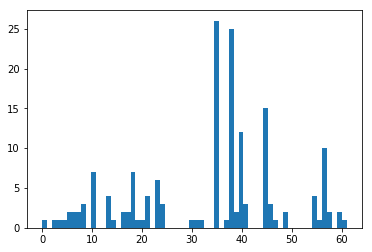

In [72]:
plt.hist(wrong_labels, bins=62)
plt.show()

Looks like the model is 100% accurate on many of the sign types, and there are just a handful of signs that account for the most errors.

In [74]:
wrong_label_counts = np.bincount(wrong_labels)
all_label_counts = np.bincount(test_labels)

In [79]:
wrong_label_counts.argsort()[::-1]

array([35, 38, 45, 40, 57, 10, 18, 23, 21, 55, 13, 46, 41, 24,  8, 49,  6,
       58,  5, 60, 39,  7, 17, 16,  4, 19,  3, 20, 14,  2, 61, 30,  0, 31,
       37, 32, 47, 56, 59, 54, 12, 52, 51,  1, 50,  9, 48, 11, 53, 29, 28,
       15, 43, 42, 36, 34, 33, 22, 25, 26, 27, 44])

So what do the signs look like that are most commonly identified incorrectly by our CNN?

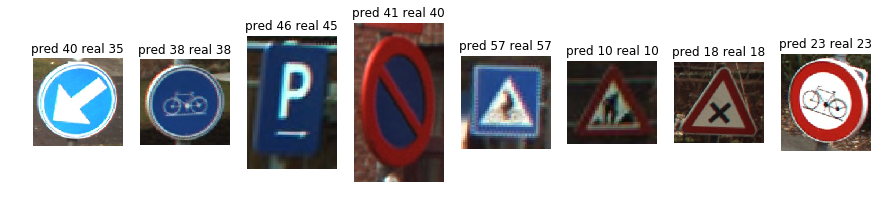

In [91]:
plt.figure(figsize=(15,5))

i=1
for label in [35, 38, 45, 40, 57, 10, 18, 23]:
    indx = np.where(test_labels==label)[0][0]
    image = test_images[indx]
    plt.subplot(1, 8, i)
    plt.imshow(image)
    plt.axis('off')
    plt.title("pred {} real {}".format(y_predict[indx], label))
    i=i+1
plt.show()

If you recall from the beginning, the class balance of labels was pretty uneven. So the most commonly misidentified signs may be skewed by the signs that are just most common, period. Below is a plot of the fraction of misidenified signs (out of the total number of that sign type in the test set) versus the number of signs of that type in the test set.

In [86]:
fraction_wrong = (wrong_label_counts/all_label_counts)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


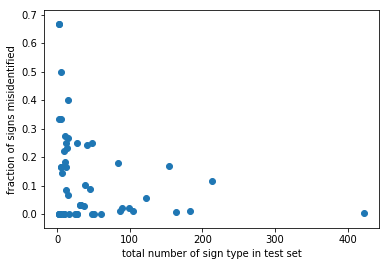

In [102]:
plt.scatter(all_label_counts, fraction_wrong)
plt.xlabel("total number of sign type in test set")
plt.ylabel("fraction of signs misidentified")
plt.show()

So some of the highest fractions of misidentified signs are in those labes with very small representation in the test set. I imagine this still holds true when you look at the training set.

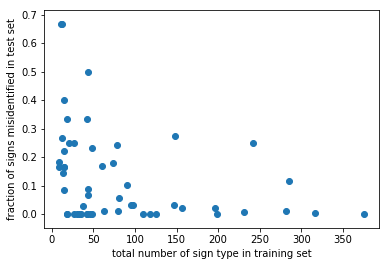

In [104]:
train_label_counts = np.bincount(labels)
plt.scatter(train_label_counts, fraction_wrong)
plt.xlabel("total number of sign type in training set")
plt.ylabel("fraction of signs misidentified in test set")
plt.show()

And indeed, this shows a trend even more strongly that for the most part, with 